# Emotion Classification with BERT

## Introduction

Emotion recognition in text is a challenging task with applications in chatbots, sentiment analysis, and mental health monitoring. In this notebook, we explore two approaches to classify text into six emotion categories—sadness, joy, love, anger, fear, and surprise—using the dair-ai/emotion dataset.

We will compare two methods:

* Fine-Tuning BERT – Train a transformer model end-to-end for emotion classification.
* SVM with Optimized Embeddings – Extract BERT embeddings and classify them using an optimized Support Vector Machine (SVM).

We will analyze the trade-offs between deep learning (BERT fine-tuning) and traditional ML (SVM with embeddings) to determine which method offers better accuracy and efficiency for emotion classification.

In [7]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [8]:
from datasets import load_dataset
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVC

## Loading Dataset & Model Initialization

- Loads the **dair-ai/emotion** dataset, which contains labeled text data for emotion classification.  
- Initializes a **BERT tokenizer** and a **BERT model** for sequence classification with six emotion labels.  
- Moves the model to **GPU (if available)** for faster training and inference.

In [9]:
# Load dataset
dataset = load_dataset("dair-ai/emotion")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=6
)

# Training setup with GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Approach 1: Fine-Tuning BERT

In this approach, we fine-tune a pre-trained BERT model by adding a classification head and training it on the dair-ai/emotion dataset. We leverage Hugging Face's Trainer API for simplified training and evaluation.

**Key Steps:**

1. **Tokenization & Preprocessing**  
   - Tokenize text using the BERT tokenizer (max_length=512).
   - Convert the text into input IDs and attention masks to prepare it for model input.
   - Rename the label column to 'labels' to align with the Trainer API's requirements.

2. **Dataset Preparation**  
   - Format the dataset into PyTorch tensors, making it compatible with the Hugging Face Trainer API.
   - Split the dataset into training and test sets.

3. **Define Training Arguments**  
   - Use `TrainingArguments` to configure training settings such as batch size, number of epochs, evaluation strategy, and logging.
   - Disable Weights & Biases (set `report_to="none"`) for local execution.

4. **Model Training with Trainer API**  
   - Utilize the Trainer API to handle automatic gradient updates, model evaluation, and checkpointing.
   - Train the model on the dataset.

5. **Model Evaluation**  
   - Use the fine-tuned model to predict labels on the test set.
   - Evaluate model performance using accuracy, a classification report, and a confusion matrix.

6. **Sample Predictions**  
   - Display sample test sentences along with their predicted and true labels for insight into the model's performance.

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.245100,0.201764
2,0.159800,0.199302
3,0.104800,0.244050



 Test Accuracy: 0.9335

 Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.98      0.97       581
         joy       0.94      0.96      0.95       695
        love       0.87      0.78      0.82       159
       anger       0.95      0.93      0.94       275
        fear       0.87      0.94      0.90       224
    surprise       0.87      0.62      0.73        66

    accuracy                           0.93      2000
   macro avg       0.91      0.87      0.89      2000
weighted avg       0.93      0.93      0.93      2000



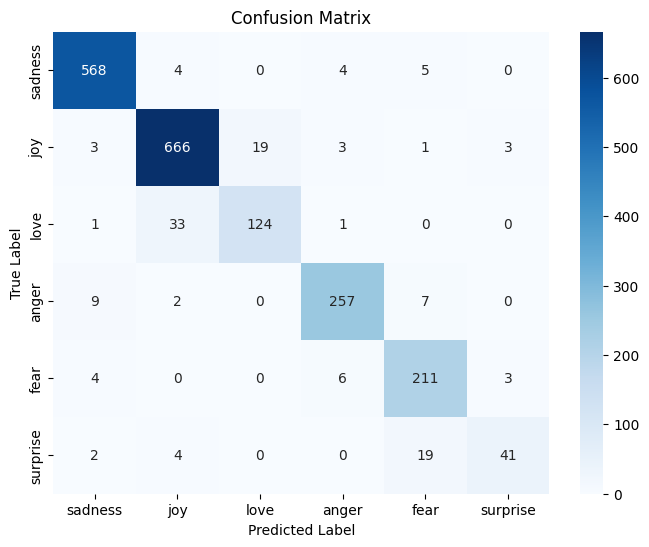


📝 **Text 1**: im feeling rather rotten so im not very ambitious right now
   ✅ **Predicted Label**: sadness
   🎯 **True Label**: sadness

📝 **Text 2**: im updating my blog because i feel shitty
   ✅ **Predicted Label**: sadness
   🎯 **True Label**: sadness

📝 **Text 3**: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
   ✅ **Predicted Label**: sadness
   🎯 **True Label**: sadness

📝 **Text 4**: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
   ✅ **Predicted Label**: joy
   🎯 **True Label**: joy

📝 **Text 5**: i was feeling a little vain when i did this one
   ✅ **Predicted Label**: sadness
   🎯 **True Label**: sadness


In [11]:
# Tokenize function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Split dataset
train_data = dataset["train"]
test_data = dataset["test"]

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none"  # Disable W&B logging
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data
)

# Train the model
trainer.train()

# Evaluate on test set
predictions = trainer.predict(test_data)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n Test Accuracy: {accuracy:.4f}")

# Print Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset["train"].features["labels"].names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset["train"].features["labels"].names, yticklabels=dataset["train"].features["labels"].names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fine-Tuning BERT")
plt.show()

# Show some sample predictions
def show_predictions(n=5):
    test_texts = dataset["test"]["text"][:n]
    for i, text in enumerate(test_texts):
        print(f"\n📝 **Text {i+1}**: {text}")
        print(f"   ✅ **Predicted Label**: {dataset['train'].features['labels'].names[y_pred[i]]}")
        print(f"   🎯 **True Label**: {dataset['train'].features['labels'].names[y_true[i]]}")

show_predictions(5)

## Results

After training the BERT model with fine-tuning and evaluating it on the test set, the model achieved the following performance:

- **Test Accuracy**: 93.35%

- **Classification Report**:
  - **Precision**:
    - Highest for *sadness* (97%) and *joy* (94%).
    - Lowest for *surprise* (87%).
  - **Recall**:
    - Highest for *sadness* (98%) and *fear* (94%).
    - Lowest for *surprise* (62%).
  - **F1-Score**:
    - Highest for *sadness* (97%) and *anger* (94%).
    - Lowest for *surprise* (73%).

- **Confusion Matrix**:
  The confusion matrix shows good predictions for most classes, with challenges in identifying *surprise*.

### Summary:
The model performed very well overall, achieving a high test accuracy of 93.35%. It excelled in detecting emotions like *sadness*, *joy*, and *anger*, while *surprise* posed a challenge, particularly in terms of recall.

## Real-Time Emotion Prediction

This function takes user input, tokenizes it using the BERT tokenizer, and feeds it into the fine-tuned model to predict the emotion. The model outputs a probability distribution over emotion labels, and the function selects the highest-scoring label as the predicted emotion.

In [12]:
# Function to predict emotion for input text
def predict_emotion(text):
    # Tokenize input text
    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    # Move tensors to the appropriate device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (emotion)
    prediction = torch.argmax(outputs.logits, dim=1).item()

    # Map prediction index to emotion label
    predicted_label = dataset["train"].features["labels"].names[prediction]
    return predicted_label

# Test with some sample input
user_input = input("Enter a sentence to predict its emotion: ")

# Get emotion prediction
predicted_emotion = predict_emotion(user_input)
print(f"Predicted Emotion: {predicted_emotion}")


Enter a sentence to predict its emotion: That looks amazing!
Predicted Emotion: joy


# Approach 2: SVM with Optimized BERT Embeddings

In this approach, we utilize pre-trained BERT to extract sentence embeddings and feed them into a Support Vector Classifier (SVC) for emotion classification. This method efficiently handles the text data by using BERT's powerful language representation and combining it with a machine learning classifier (SVC) for final predictions.

**Steps**:
1. **Embedding Extraction**: Use the model to generate embeddings for both training and testing data. We process the data in batches for improved efficiency.
2. **Model Training**: Train a Linear SVC model using the extracted BERT embeddings.
3. **Prediction & Evaluation**: Evaluate the model on the test data by predicting emotions, calculating accuracy, and generating a classification report.
4. **Confusion Matrix**: Visualize model performance using a confusion matrix to understand the errors made by the classifier.


Test Accuracy: 0.5235

Classification Report:
              precision    recall  f1-score   support

     sadness       0.67      0.53      0.59       581
         joy       0.76      0.53      0.63       695
        love       0.25      0.45      0.32       159
       anger       0.44      0.52      0.48       275
        fear       0.49      0.51      0.50       224
    surprise       0.19      0.58      0.28        66

    accuracy                           0.52      2000
   macro avg       0.47      0.52      0.47      2000
weighted avg       0.60      0.52      0.55      2000



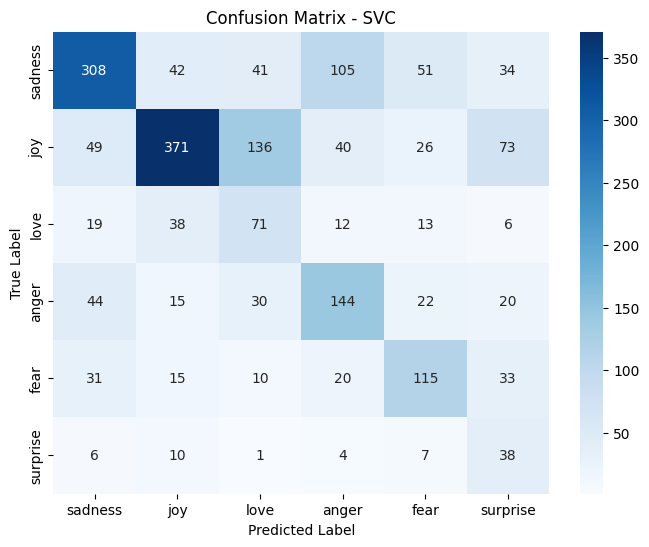

In [25]:
model.eval()

# Function to get embeddings (using [CLS] token for classification tasks)
def get_embeddings_batch(text_list, batch_size=16):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt")
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)  # Request hidden states
        # Extract embeddings from the [CLS] token (first token of each sequence)
        cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()  # Using last layer's CLS token
        embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

# Get embeddings for training & test data
train_texts = dataset["train"]["text"]
test_texts = dataset["test"]["text"]
X_train = get_embeddings_batch(train_texts)
X_test = get_embeddings_batch(test_texts)

# Labels
y_train = np.array(dataset["train"]["label"])
y_test = np.array(dataset["test"]["label"])

# Train basic SVC model
svc_model = SVC(kernel="rbf", class_weight='balanced')
svc_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svc_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=dataset["train"].features["label"].names))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset["train"].features["label"].names,
            yticklabels=dataset["train"].features["label"].names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVC")
plt.show()

## Results

After training the SVC model with the BERT embeddings and evaluating it on the test set, the model achieved the following performance:

- **Test Accuracy**: 52.35%

- **Classification Report**:
  - **Precision**:
    - Highest for *joy* (76%) and *sadness* (67%).
    - Lowest for *surprise* (19%).
  - **Recall**:
    - Highest for *surprise* (58%) and *love* (45%).
    - Lowest for *joy* (53%).
  - **F1-Score**:
    - Highest for *sadness* (0.59) and *joy* (0.63).
    - Lowest for *surprise* (0.28).

- **Confusion Matrix**:
  The confusion matrix indicates that the model struggles with predicting *surprise*, often confusing it with other emotions, while it performs better for *joy* and *sadness*.

### Summary:
The model achieved a test accuracy of 52.35%, which is a decent baseline but highlights the challenges with certain classes like *love* and *surprise*. The model performed best for *joy* and *sadness*, with precision being higher for these classes. However, the low precision and F1-score for *surprise* indicate a need for further improvement in identifying this class. Fine-tuning the model further or exploring other techniques could improve performance, especially in the underperforming categories.